In [1]:
%matplotlib inline

import itertools
from tqdm import tqdm
from tqdm import trange
from functools import partial
from multiprocessing import Pool, cpu_count
import numpy as np
# np.seterr(all='ignore')
import scipy.special as special
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.interpolate as interpolate
from scipy.stats import rv_continuous, poisson, uniform
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 1.0
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
def glow(n, tau):
    return np.random.exponential(tau, size=n)

def transit(n, sigma):
    return np.random.normal(0, sigma, size=n)

def time(n, tau, sigma):
    return glow(n, tau) + transit(n, sigma)

def convolve_exp_norm(x, tau, sigma):
    if sigma == 0:
        y = np.where(x > 0, 1/tau * np.exp(-x/tau), 0)
    else:
        alpha = 1/tau
        co = alpha/2. * np.exp(alpha*alpha*sigma*sigma/2.)
        x_erf = (alpha*sigma*sigma - x)/(np.sqrt(2.)*sigma)
        y = co * np.exp(-alpha*x) * (1. - special.erf(x_erf))
    return y

def start_time(a0, a1, mu, tau, sigma):
    stime = np.zeros(a1 - a0)
    samples = [np.sort(time(n, tau, sigma)) for n in 
               poisson.ppf(1 - uniform.rvs(scale=1-poisson.cdf(0, mu), size=a1 - a0), mu).astype(np.int)]
    for i in range(a1 - a0):
        logL = lambda t0 : -1 * np.sum(np.log(np.clip(convolve_exp_norm(samples[i] - t0, tau, sigma), 
                                                      np.finfo(np.float).tiny, np.inf)))
        stime[i] = optimize.minimize(logL, x0=0, method='BFGS')['x']
    return stime, samples

def deltatime(mu, tau, sigma):
    with Pool(min(Ncpu, cpu_count())) as pool:
        result = pool.starmap(partial(start_time, mu=mu, tau=tau, sigma=sigma), slices)

    stime = np.concatenate([result[i][0] for i in range(len(slices))])
    samples = list(itertools.chain.from_iterable([result[i][1] for i in range(len(slices))]))
        
    deltat = stime
    deltat0 = np.array([samples[i][0] for i in range(N)])
    std = np.std(deltat, ddof=-1)
    std0 = np.std(deltat0, ddof=-1)
    return deltat, deltat0, std, std0

In [3]:
N = 10000
Ncpu = 100
chunk = N // Ncpu + 1
slices = np.vstack((np.arange(0, N, chunk), np.append(np.arange(chunk, N, chunk), N))).T.astype(np.int).tolist()

Mu = np.arange(2, 22, 5).astype(np.int)
Tau = np.arange(10, 40, 10).astype(np.int)
Sigma = np.arange(1, 11, 5).astype(np.int)
Deltat = np.zeros((len(Mu), len(Tau), len(Sigma), N))
Deltat0 = np.zeros((len(Mu), len(Tau), len(Sigma), N))
Std = np.zeros((len(Mu), len(Tau), len(Sigma)))
Std0 = np.zeros((len(Mu), len(Tau), len(Sigma)))

In [4]:
np.random.seed(0)
for m in trange(len(Mu), desc='   mu'):
    for t in trange(len(Tau), desc='  tau'):
        for s in trange(len(Sigma), desc='sigma'):
            mu = Mu[m]
            tau = Tau[t]
            sigma = Sigma[s]
            
            Deltat[m, t, s], Deltat0[m, t, s], Std[m, t, s], Std0[m , t, s] = deltatime(mu, tau, sigma)

            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_axes((.1, .1, .8, .8))
            ax.hist(Deltat[m, t, s], bins=100, alpha=0.5, color='b', label='all PE')
            ax.hist(Deltat0[m, t, s], bins=100, alpha=0.5, color='r', label='1st PE')
            ax.set_xlabel(r'$\Delta t/\mathrm{ns}$')
            ax.set_ylabel(r'$Count$')
            ax.set_title(r'$\mu=${:.01f}'.format(mu) + r'$\mathrm{ns}\ $' + 
                         r'$\tau=${:.01f}'.format(tau) + r'$\mathrm{ns}\ $' + 
                         r'$\sigma=${:.01f}'.format(sigma) + r'$\mathrm{ns}\ $' + 
                         r'$\mathrm{N}=$' + '{:2d}\n'.format(N) + 
                         r'$\delta_{1st}-\delta_{all}=$' + 
                         r'{:.02f}$-${:.02f}$=${:.02f}'.format(Std0[m , t, s], Std[m, t, s], Std0[m , t, s] - Std[m, t, s]) + 
                         r'$\mathrm{ns}$')
            ax.legend()
            fig.savefig('img/vs/vs-{:02d}-{:02d}-{:02d}.png'.format(mu, tau, sigma))
            plt.close()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes((.1, .1, .8, .8))
ax.hist(Deltat.flatten(), bins=100, alpha=0.5, color='b', label='all PE')
ax.hist(Deltat0.flatten(), bins=100, alpha=0.5, color='r', label='1st PE')
ax.set_xlabel(r'$\Delta t/\mathrm{ns}$')
ax.set_ylabel(r'$Count$')
ax.set_title(r'$\mathrm{N}=$' + '{:2d}\n'.format(N) + 
             r'$\delta_{1st}-\delta_{all}=$' + 
             r'{:.02f}$-${:.02f}$=${:.02f}'.format(np.std(Deltat0, ddof=-1), np.std(Deltat, ddof=-1), np.std(Deltat0, ddof=-1) - np.std(Deltat, ddof=-1)) + 
             r'$\mathrm{ns}$')
ax.legend()
fig.savefig('img/vs/vs.png')
plt.close()

  tau:   0%|          | 0/3 [00:00<?, ?it/s]

sigma:   0%|          | 0/2 [00:00<?, ?it/s]

sigma:  50%|█████     | 1/2 [00:01<00:01,  1.84s/it]

sigma: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]

  tau:  33%|███▎      | 1/3 [00:03<00:06,  3.11s/it]

sigma:   0%|          | 0/2 [00:00<?, ?it/s]

sigma:  50%|█████     | 1/2 [00:01<00:01,  1.74s/it]

sigma: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]

  tau:  67%|██████▋   | 2/3 [00:06<00:03,  3.11s/it]

sigma:   0%|          | 0/2 [00:00<?, ?it/s]

sigma:  50%|█████     | 1/2 [00:01<00:01,  1.82s/it]

sigma: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]

  tau:   0%|          | 0/3 [00:00<?, ?it/s]

sigma:   0%|          | 0/2 [00:00<?, ?it/s]

sigma:  50%|█████     | 1/2 [00:01<00:01,  1.45s/it]

sigma: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

  tau:  33%|███▎      | 1/3 [00:02<00:05,  2.83s/it]

sigma:   0%|          | 0/2 [00:00<?, ?it/s]

sigma:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it]

sigma: 100%|██████████| 2/2 [0

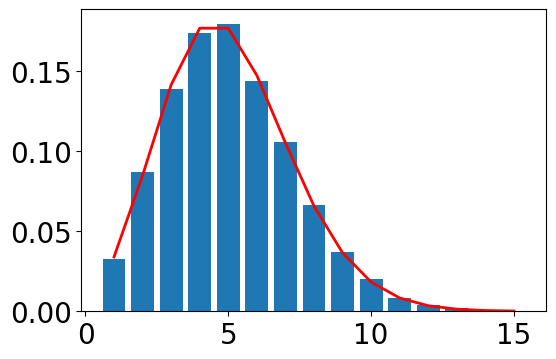

In [5]:
mu = 5
sample = poisson.ppf(1 - uniform.rvs(scale=1-poisson.cdf(0, mu), size=10000), mu).astype(np.int)
n, s = np.unique(sample, return_counts=True)
s = s / np.sum(s)
plt.close()
plt.bar(n, s)
f = np.diff(poisson.cdf(np.insert(n, 0, 0), mu))
f = f / np.sum(f)
plt.plot(n, f, color='r')